# Esteganografia *Least Significant Bit* em Escala de Cinza

Técnica de esteganografia que consiste em alterar os dois últimos bits de cada píxel da imagem para armazenar a mensagem secreta

In [7]:
!pip3 install bitarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importação de Bibliotecas**

In [9]:
from skimage.io import imread, imsave, imshow
from skimage.metrics import structural_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm
from bitarray import bitarray
from bitarray.util import int2ba
import numpy as np
import os
import random
import string
import itertools
import lpips
import torch
import math
import os
import time

In [10]:
start_time = time.time()

**Definição da semente do gerador de números aleatórios para permitir a reprodução dos experimentos realizados**

In [11]:
os.environ['PYTHONHASHSEED']=str(456)
np.random.seed(456)
random.seed(456)

**Leitura do dataset de imagens**

In [12]:
dataset_imagens_originais = []

for i in tqdm(os.listdir('dataset')):
  imagem_atual = imread('dataset/' + i)

  if len(imagem_atual.shape) != 3:
    continue

  dataset_imagens_originais.append(imagem_atual)

dataset_imagens_originais = np.array(dataset_imagens_originais)

100%|██████████| 10000/10000 [00:05<00:00, 1875.18it/s]


In [13]:
dataset_imagens_originais = dataset_imagens_originais[:4881]

In [14]:
dataset_imagens_originais.shape

(4881, 64, 64, 3)

**Conversão das imagens de RGB para escala de cinza**

In [15]:
def paraEscalaDeCinza(imagemRGB):
	    r = imagemRGB[:,:,0]
	    g = imagemRGB[:,:,1]
	    b = imagemRGB[:,:,2]

	    shapeImagem = imagemRGB.shape;
	    imagemCinza = np.zeros((shapeImagem[0], shapeImagem[1]))

	    for i in range(shapeImagem[0]):
	        for j in range(shapeImagem[1]):
	            imagemCinza[i][j] = int(0.2126*r[i][j] + 0.7152*g[i][j] + 0.0722*b[i][j])

	    return imagemCinza.astype("uint8")

In [16]:
dataset_imagens_escala_de_cinza = []

for img in tqdm(dataset_imagens_originais):
  img_escala_de_cinza = paraEscalaDeCinza(img)
  dataset_imagens_escala_de_cinza.append(img_escala_de_cinza)

dataset_imagens_originais = np.array(dataset_imagens_escala_de_cinza)

100%|██████████| 4881/4881 [02:49<00:00, 28.81it/s]


**Cálculo do tamanho disponível para armazenamento da mensagem secreta nas imagens do dataset**

In [17]:
bytes_por_imagem = np.prod(dataset_imagens_originais[0].shape)

In [18]:
espaco_bits_mensagem_secreta = bytes_por_imagem * 2 # serão utilizados os dois bits menos significativos de cada byte para armazenar a mensagem secreta

In [19]:
espaco_bytes_mensagem_secreta = espaco_bits_mensagem_secreta // 8

**Geração das mensagens secretas consistindo em strings aleatórias**

Será utilizado a coficação ASCII, portanto para cada caracter é nescessário utilizar um byte

In [20]:
string_mensagens_secretas = []

for i in tqdm(range(dataset_imagens_originais.shape[0])):
  mensagem_secreta = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(espaco_bytes_mensagem_secreta))
  string_mensagens_secretas.append(mensagem_secreta)

100%|██████████| 4881/4881 [00:05<00:00, 903.84it/s]


**Converte a lista de strings para uma lista de bitarrays representado a string**

In [21]:
bitarray_mensagens_secretas = []

for mensagem_secreta in tqdm(string_mensagens_secretas):
  bitarray_mensagem = bitarray()
  
  for caracter in mensagem_secreta:
    bitarray_mensagem += int2ba(ord(caracter), length=8)
  
  bitarray_mensagens_secretas.append(bitarray_mensagem)

100%|██████████| 4881/4881 [00:16<00:00, 293.24it/s]


**Armazena cada mensagem secreta nos dois bits menos significativos de cada canal de cada pixel da imagem**

In [22]:
def armazena_steganografia_no_byte(valor_byte, valor_stegano1, valor_setagno2):
  valor_byte = int(valor_byte)

  if valor_stegano1 == 1:
    valor_byte |= 2
  else:
    valor_byte &= (~2)
  
  if valor_setagno2 == 1:
    valor_byte |= 1
  else:
    valor_byte &= (~1)

  return valor_byte

In [23]:
dataset_imagens_esteganografia = []

dimensao_imagens = dataset_imagens_originais[0].shape

for i in tqdm(range(dataset_imagens_originais.shape[0])):
  imagem_esteganografia = np.array(dataset_imagens_originais[i], copy=True)

  contador_bit_esteganografia = 0

  for posicao_imagem in itertools.product(range(dimensao_imagens[0]), range(dimensao_imagens[1])):
    bit1_esteganografia = bitarray_mensagens_secretas[i][2 * contador_bit_esteganografia]
    bit2_esteganografia = bitarray_mensagens_secretas[i][2 * contador_bit_esteganografia + 1]

    contador_bit_esteganografia += 1

    imagem_esteganografia[posicao_imagem[0]][posicao_imagem[1]] = armazena_steganografia_no_byte(imagem_esteganografia[posicao_imagem[0]][posicao_imagem[1]], bit1_esteganografia, bit2_esteganografia)

  dataset_imagens_esteganografia.append(imagem_esteganografia)

dataset_imagens_esteganografia = np.array(dataset_imagens_esteganografia)

100%|██████████| 4881/4881 [00:34<00:00, 139.78it/s]


**Salva o dataset de imagens contendo esteganografia utilizando o formato bmp**

In [24]:
os.mkdir('dataset_esteganografia')

contador_imagem = 0

for imagem in tqdm(dataset_imagens_esteganografia):
  imsave('dataset_esteganografia/' + str(contador_imagem) + '.bmp', imagem)
  contador_imagem += 1

100%|██████████| 4881/4881 [00:03<00:00, 1415.38it/s]


**Extrai a mensagem secreta das imagens com esteganografia**

In [25]:
def extrai_steganografia_no_byte(valor_byte):
  return (valor_byte >> 1) & 1, valor_byte & 1

In [26]:
dimensao_imagens = dataset_imagens_esteganografia[0].shape

lista_mensagem_esteganografia_recuperada = []

for i in tqdm(range(dataset_imagens_esteganografia.shape[0])):
  imagem_esteganografia = dataset_imagens_esteganografia[i]
  bitarray_mensagem = bitarray()

  for posicao_imagem in itertools.product(range(dimensao_imagens[0]), range(dimensao_imagens[1])):
    bit1_esteganografia, bit2_esteganografia = extrai_steganografia_no_byte(imagem_esteganografia[posicao_imagem[0]][posicao_imagem[1]])

    bitarray_mensagem += int2ba(int(bit1_esteganografia), length=1)
    bitarray_mensagem += int2ba(int(bit2_esteganografia), length=1)

  lista_mensagem_esteganografia_recuperada.append(bitarray_mensagem)

100%|██████████| 4881/4881 [04:03<00:00, 20.04it/s]


**Verifica se todas as mensagens secretas foram extaídas corretamente**

In [27]:
mensagem_incorreta = False

for i in range(len(lista_mensagem_esteganografia_recuperada)):
  if lista_mensagem_esteganografia_recuperada[1] != bitarray_mensagens_secretas[1]:
    print("Existe pelo menos uma mensagem recuperada incorretamente")
    mensagem_incorreta = True

if not mensagem_incorreta:
  print("Todas as mensagens foram recuperadas corretamente")

Todas as mensagens foram recuperadas corretamente


**Calcula as metricas de qualidade da imagem visando comparar as imagens originais com as imagens contendo esteganografia**

In [28]:
def mean_squared_error(a, b):
  t = 0
  n = 0
  
  for i in range(a.shape[0]):
    for j in range(a.shape[1]):
      t += (a[i][j] - b[i][j])**2
      n += 1
  
  t /= n

  return t

In [29]:
def peak_signal_to_noise_ratio(mse):
  return 10 * math.log10((255**2)/(mse))

In [30]:
dataset_imagens_originais = dataset_imagens_originais.astype('int')

In [31]:
dataset_imagens_esteganografia = dataset_imagens_esteganografia.astype('int')

In [32]:
diff = np.abs(dataset_imagens_originais - dataset_imagens_esteganografia)

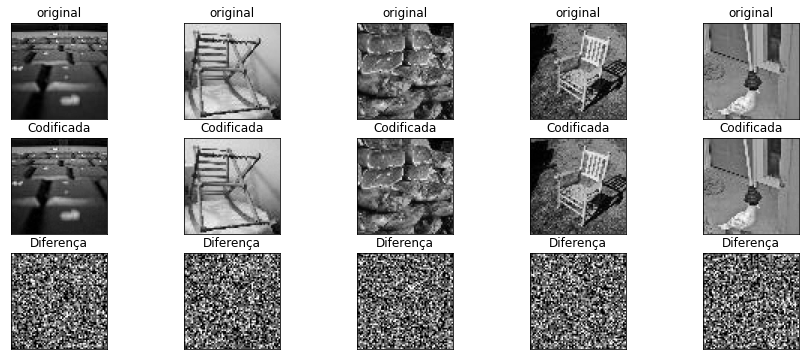

In [33]:
n = 5
plt.figure(figsize=(15, 6))
for i in range(n):
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(dataset_imagens_originais[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i + 1 + n)
  plt.imshow(dataset_imagens_esteganografia[i])
  plt.title("Codificada")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
    
  ax = plt.subplot(3, n, i + 1 + n + n)
  plt.imshow(diff[i] * 10)
  plt.title("Diferença")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.savefig('dieferença_imagens.png')
plt.show()

In [34]:
mseMedio = 0
psnrMedio = 0
ssimMedio = 0

mseVet = []
psnrVet = []
ssimVet = []

for i in range(dataset_imagens_originais.shape[0]):
  mse = mean_squared_error(dataset_imagens_originais[i], dataset_imagens_esteganografia[i])
  mseMedio += mse
  mseVet.append(mse)

  psnr = peak_signal_to_noise_ratio(mse)
  psnrMedio += psnr
  psnrVet.append(psnr)

  ssim = structural_similarity(dataset_imagens_originais[i], dataset_imagens_esteganografia[i], multichannel=True)
  ssimMedio += ssim
  ssimVet.append(ssim)

mseMedio /= dataset_imagens_originais.shape[0]
psnrMedio /= dataset_imagens_originais.shape[0]
ssimMedio /= dataset_imagens_originais.shape[0]

print('MSE Médio:', mseMedio)
print('PSNR Médio:', psnrMedio)
print('SSIM Médio:', ssimMedio)

MSE Médio: 2.3049731560355204
PSNR Médio: 44.50575518066964
SSIM Médio: 1.0


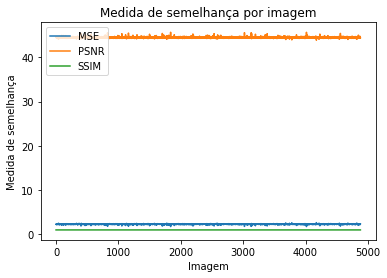

In [35]:
legend = []

plt.plot(mseVet)
legend.append('MSE')
plt.plot(psnrVet)
legend.append('PSNR')
plt.plot(ssimVet)
legend.append('SSIM')
plt.title('Medida de semelhança por imagem')
plt.ylabel('Medida de semelhança')
plt.xlabel('Imagem')
plt.legend(legend, loc='upper left')
plt.savefig('medida_de_semelhança_por_imagem_1.png')
plt.show()

In [36]:
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

--- Execution time: 558.0326044559479 seconds ---
